# Ripe-Atlas log analisis scripts

This notebook is intended to plot and analyze logs from ripe-atlas probes.

The *log_url* varible is the url that appears in "Download URL Preview" in the "Download logs" section of the "Built-Ins" tab of the probe information page. In json format.

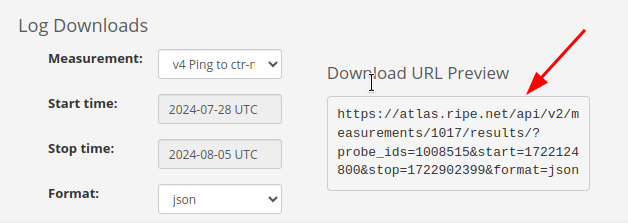


## Ping logs


In [16]:
# @title Load file - use the input on the right to place the url with PING logs and run this box.

import requests
import time
from io import StringIO
import pandas as pd

dataframes = []

log_url = "https://atlas.ripe.net/api/v2/measurements/1001/results/?probe_ids=1008517&start=1725494400&stop=1725839999&format=json" #@param {type:"string"}
data = requests.get(log_url)
ping_df = pd.read_json(StringIO(data.text))
df_sorted = ping_df.sort_values('timestamp', ascending=True)
dataframes.append(df_sorted)
ping_df.head()


log_url_1 = "" #@param {type:"string"}
if log_url_1 != "":
  time.sleep(2)
  data = requests.get(log_url_1)
  ping_df = pd.read_json(StringIO(data.text))
  df_sorted = ping_df.sort_values('timestamp', ascending=True)
  dataframes.append(df_sorted)

log_url_2 = "" #@param {type:"string"}
if log_url_2 != "":
  time.sleep(5)
  data = requests.get(log_url_2)
  ping_df = pd.read_json(StringIO(data.text))
  df_sorted = ping_df.sort_values('timestamp', ascending=True)
  dataframes.append(df_sorted)

# concatenate dataframes
ping_df = pd.concat(dataframes)





In [17]:
# @title Graph time vs avg RTT
from io import StringIO
import pandas as pd
import plotly.express as px


# supress future warning triggerd by protly
import warnings
warnings.simplefilter("ignore", category=FutureWarning)

"""
# sort daset by timestam
df_sorted = ping_df.sort_values('timestamp', ascending=True)
df_sorted_1 = ping_df_1.sort_values('timestamp', ascending=True)

# Concatenate the two dataframes
df_concat = pd.concat([df_sorted, df_sorted_1])
"""

# Assuming df_sorted is your dataframe with 'timestamp' and 'avg' columns
title = "Probe  {} to: ".format(df_sorted['prb_id'][0])
for n in ping_df['msm_id'].unique():
  dst_addr = ping_df[ping_df['msm_id']== n]['dst_addr'][0]
  title += "<{}={}> ".format(n, dst_addr)

fig = px.line(ping_df, x='timestamp', y='min', color='msm_id', title=title)

# Customize hover data
fig.update_traces(hovertemplate="<b>Date: %{x}</b><br>Avg: %{y}")

fig.show()



## HTTP Logs

These logs have connections made to http servers of the ripe infrastructure, the connections are made in ~1 hour intervals.

In [6]:
# @title Load file - use the input on the right to place the url with HTTP logs and run this box.

import requests

log_url = "https://atlas.ripe.net/api/v2/measurements/12027/results/?probe_ids=1008517&start=1725494400&stop=1725839999&format=json" #@param {type:"string"}
data = requests.get(log_url)
http_df = pd.read_json(StringIO(data.text))
http_df.head()


,fw,mver,lts,result,uri,msm_id,prb_id,timestamp,msm_name,from,type,stored_timestamp
0,5080,2.6.2,816873,"[{'header': ['X-Client-IP: 186.118.170.139', '...",http://193.0.6.141,12027,1008517,2024-09-05 00:29:17,HTTPGet,186.118.170.139,http,1725496234
1,5080,2.6.2,820474,"[{'header': ['X-Client-IP: 186.118.170.139', '...",http://193.0.6.141,12027,1008517,2024-09-05 01:29:19,HTTPGet,186.118.170.139,http,1725499842
2,5080,2.6.2,824073,"[{'header': ['X-Client-IP: 186.118.170.139', '...",http://193.0.6.141,12027,1008517,2024-09-05 02:29:17,HTTPGet,186.118.170.139,http,1725503448
3,5080,2.6.2,827672,"[{'header': ['X-Client-IP: 186.118.170.139', '...",http://193.0.6.141,12027,1008517,2024-09-05 03:29:17,HTTPGet,186.118.170.139,http,1725507032
4,5080,2.6.2,831271,"[{'header': ['X-Client-IP: 186.118.170.139', '...",http://193.0.6.141,12027,1008517,2024-09-05 04:29:16,HTTPGet,186.118.170.139,http,1725510630


In [7]:
# @title Table: Disconected time intervals (shows time intervals where the time difference is more than 1.1 hours)
from io import StringIO
import pandas as pd

# sort daset by timestam
df_sorted = http_df.sort_values('timestamp', ascending=True)

# Calculate time differences in hours
time_diffs_in_hours = df_sorted['timestamp'].diff() / pd.Timedelta(hours=1)

# Create a DataFrame with disconnection information
disconnection_df = pd.DataFrame({
    'Start Time': df_sorted['timestamp'].shift(1),
    'End Time': df_sorted['timestamp'],
    'Disconnection Time (hours)': time_diffs_in_hours
}).dropna()

# Filter for disconnections longer than an hour
disconnection_df = disconnection_df[disconnection_df['Disconnection Time (hours)'] > 1.1]

# Format the timestamps for better readability (optional)
disconnection_df['Start Time'] = disconnection_df['Start Time'].dt.strftime('%Y-%m-%d %H:%M')
disconnection_df['End Time'] = disconnection_df['End Time'].dt.strftime('%Y-%m-%d %H:%M')

# Get the start and end time of the entire dataset
dataset_start_time = df_sorted['timestamp'].min().strftime('%Y-%m-%d %H:%M')
dataset_end_time = df_sorted['timestamp'].max().strftime('%Y-%m-%d %H:%M')

# Get the probe id
probe_id = df_sorted['prb_id'][0]

# Get uri
uri = df_sorted['uri'][0]

# Print the dataset time range
print(f"Time Range for probe {probe_id}: {dataset_start_time} to {dataset_end_time} for {uri}")

# Display the table
disconnection_df


Time Range for probe 1008517: 2024-09-05 00:29 to 2024-09-08 21:29 for http://193.0.6.141


,Start Time,End Time,Disconnection Time (hours)


## Traceroute logs

In [8]:
# @title Load file - use the input on the right to place the url with TRACEROUTE logs and run this box.
import pandas as pd
from io import StringIO
import requests

log_url = "https://atlas.ripe.net/api/v2/measurements/5001/results/?probe_ids=1008517&start=1725494400&stop=1725839999&format=json" #@param {type:"string"}
data = requests.get(log_url)
tr_df = pd.read_json(StringIO(data.text))
tr_df.head()

,fw,mver,lts,endtime,dst_name,dst_addr,src_addr,proto,af,size,paris_id,result,destination_ip_responded,msm_id,prb_id,timestamp,msm_name,from,type,stored_timestamp
0,5080,2.6.2,815268,1725494553,193.0.14.129,193.0.14.129,192.168.3.134,UDP,4,40,8,"[{'hop': 1, 'result': [{'from': '192.168.3.1',...",True,5001,1008517,2024-09-05 00:02:20,Traceroute,186.118.170.139,traceroute,1725494612
1,5080,2.6.2,817066,1725496351,193.0.14.129,193.0.14.129,192.168.3.134,UDP,4,40,9,"[{'hop': 1, 'result': [{'from': '192.168.3.1',...",True,5001,1008517,2024-09-05 00:32:18,Traceroute,186.118.170.139,traceroute,1725496423
2,5080,2.6.2,818863,1725498148,193.0.14.129,193.0.14.129,192.168.3.134,UDP,4,40,10,"[{'hop': 1, 'result': [{'from': '192.168.3.1',...",True,5001,1008517,2024-09-05 01:02:17,Traceroute,186.118.170.139,traceroute,1725498212
3,5080,2.6.2,820668,1725499953,193.0.14.129,193.0.14.129,192.168.3.134,UDP,4,40,11,"[{'hop': 1, 'result': [{'from': '192.168.3.1',...",True,5001,1008517,2024-09-05 01:32:20,Traceroute,186.118.170.139,traceroute,1725500029
4,5080,2.6.2,822465,1725501750,193.0.14.129,193.0.14.129,192.168.3.134,UDP,4,40,12,"[{'hop': 1, 'result': [{'from': '192.168.3.1',...",True,5001,1008517,2024-09-05 02:02:18,Traceroute,186.118.170.139,traceroute,1725501816


In [9]:
# @title Graph of number of hops for each measurement on a time line

import plotly.graph_objects as go
import pandas as pd

# Calculate the hop count for each traceroute
tr_df['hop_count'] = tr_df['result'].apply(len)

# Sort the dataframe by timestamp
tr_df = tr_df.sort_values('timestamp', ascending=True)
tr_df = tr_df.reset_index(drop=True)

# Calculate hop count
tr_df['hop_count'] = tr_df['result'].apply(len)

# Create hover text
result_index = 0

def hover_text(row):
  global result_index
  text = "index: {}<br>".format(result_index)
  text += "{}<br><br>".format(row['timestamp'])
  result = row['result']
  for n in result:
    text += "{}: ".format(n['hop'])
    from_found = False
    if 'error' in n:
      text += "Error: {}<br>".format(n['error'])
      continue
    for m in n['result']:
      if 'from' in m:
        text += m['from'] + "<br>"
        from_found = True
        break
    if not from_found:
        text += "*<br>"
  result_index += 1
  return text

tr_df['hover_text'] = tr_df.apply(hover_text, axis=1)

# Create the plot
fig = go.Figure(data=go.Scatter(x=tr_df['timestamp'],
                                y=tr_df['hop_count'],
                                mode='lines+markers',
                                text=tr_df['hover_text'],
                                hoverinfo='text'))

# Customize the plot (optional)
fig.update_layout(title='Traceroute Hop Count Over Time',
                  xaxis_title='Time',
                  yaxis_title='Hop Count')

# Display the plot
fig.show()

In [11]:
# @title Table: Compare two traceroute measurements using the indexes shown on last graph

index1 = "57" # @param {type:'string'}
index2 = "55" # @param {type:'string'}

# Select the first two rows and reset their indices
df1 = tr_df.iloc[[index1]].reset_index(drop=True)
df2 = tr_df.iloc[[index2]].reset_index(drop=True)

# Reorder columns to place 'result' last
new_column_order = [col for col in df1.columns if col != 'result'] + ['result']
df1 = df1[new_column_order]
df2 = df2[new_column_order]

# Compare the DataFrames and format the output
comparison = df1.compare(df2, align_axis='rows', keep_shape=True, keep_equal=True)

# # Custom styling function to pretty-print 'result' column
# def pretty_print_result(val):
#   s = ""
#   for n in val:
#     s += "{}:&nbsp;&nbsp;&nbsp;".format(n['hop'])
#     for m in n['result']:
#       if 'from' in m:
#         s += "&nbsp;{}".format(m['from'])
#       else:
#         s += "&nbsp;*"
#     s += "<br>"
#   return s

# # Pre-process the 'result' column to pretty-print JSON
# comparison['result'] = comparison['result'].apply(pretty_print_result)

# Transpose for better readability (optional)
comparison_transposed = comparison.transpose()

# Rename the columns for clarity
comparison_transposed.columns = ["index :{}".format(index1), "index :{}".format(index2)]

# Apply the styling, including custom formatting for 'result'
styled_comparison = comparison_transposed.style.set_properties(**{'text-align': 'left'}) \
                                   .set_table_styles([dict(selector='th', props=[('text-align', 'left')])])

# Display the styled comparison
display(styled_comparison)


,index :57,index :55
fw,5080,5080
mver,2.6.2,2.6.2
lts,917872,914264
endtime,1725597157,1725593549
dst_name,193.0.14.129,193.0.14.129
dst_addr,193.0.14.129,193.0.14.129
src_addr,192.168.3.134,192.168.3.134
proto,UDP,UDP
af,4,4
size,40,40
